# Motion planner cut in small pieces for easy debugging

In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import utm

from planning_utils import a_star, heuristic #, create_grid
from planning_tools import create_grid, create_grid_and_edges, prune_path, heuristic_func, find_start_goal
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local
from udacidrone.frame_utils import local_to_global

from skimage.morphology import medial_axis
from skimage.util import invert


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
colliders_file = 'colliders.csv'
with open(colliders_file) as f:
    latlon = f.readline().strip().split(',')
    lat0 = float(latlon[0].replace("lat0 ", ""))
    lon0 = float(latlon[1].replace("lon0 ", ""))
    print('lat: ', lat0)
    print('lon: ', lon0)



lat:  37.79248
lon:  -122.39745


-316.0 605.0
-445.0 476.0
921 921


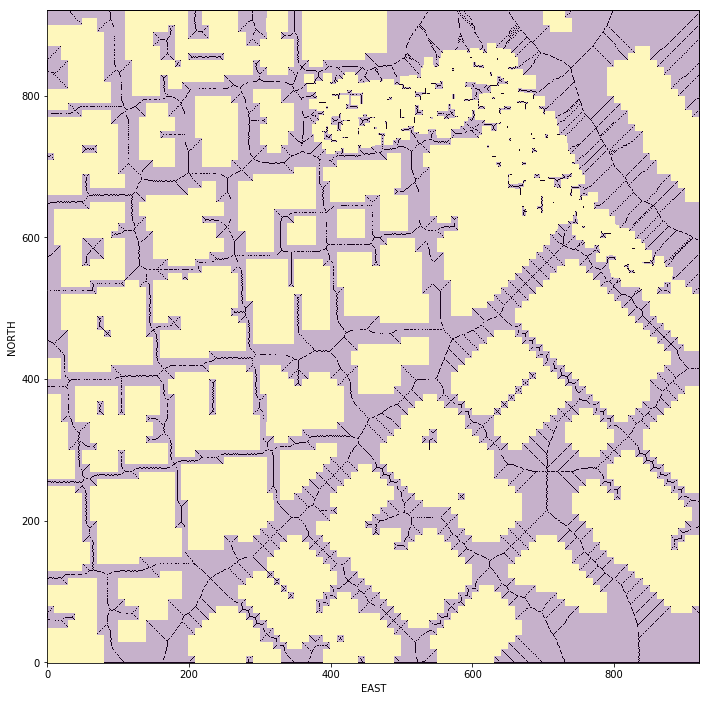

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
# print(data)
# Static drone altitude (meters)
drone_altitude = 5
# Minimum distance stay away from obstacle (meters)
safe_distance = 5

grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)
#grid, edges, north_offset, east_offset = create_grid_and_edges(data, drone_altitude, safe_distance)
skeleton = medial_axis(invert(grid))

# first show the midial grid
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
#plt.plot(grid_start[1], grid_start[0], 'rx')
#plt.plot(grid_goal[1], grid_goal[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()



    

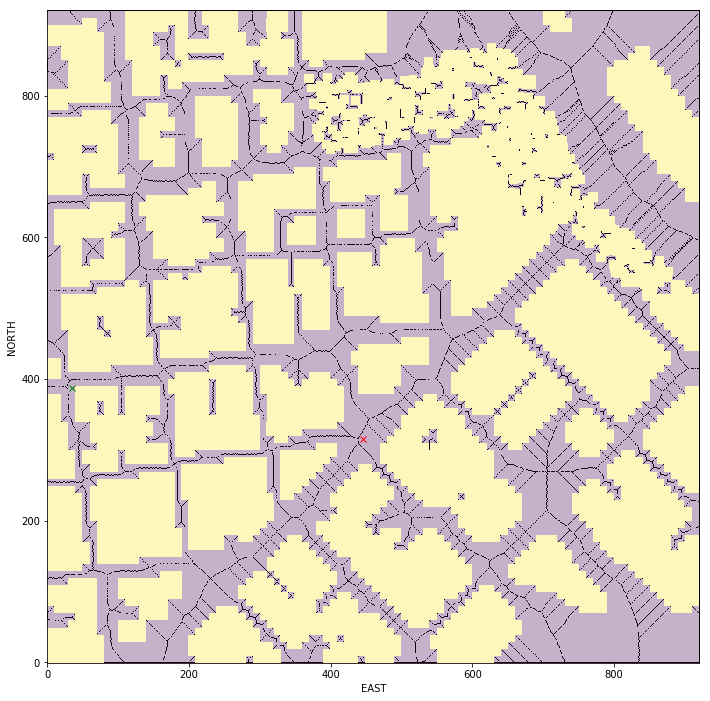

In [20]:

#set grid start and grid goal
# start to pos 1
#grid_start = (316,445)
#grid_goal = (626, 820)

#grid_start = (625, 819)
#grid_goal = (820, 250)

#grid_start = (820, 251)
#grid_goal  = (388, 35)

grid_start = (388,35)
grid_goal  = (316, 445)

# from pos 1 to pos 2#
#grid_start = (815, 247)
#grid_goal = (427, 418)

# from pos 2 to pos 3
#grid_start = (426,418)
#grid_goal  = (388, 35)

# from pos 3 back to start
#grid_start = (387,35)
#grid_goal  = (316, 445)

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(grid_start[1], grid_start[0], 'gx')
plt.plot(grid_goal[1], grid_goal[0], 'rx')


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()



In [21]:
skel_start, skel_goal = find_start_goal(skeleton, grid_start, grid_goal)

print('original start and goal: ',grid_start, grid_goal)
print('start and goal on skeleton: ', skel_start, skel_goal)

original start and goal:  (388, 35) (316, 445)
start and goal on skeleton:  [385  29] [320 441]


In [22]:
# a star search with median grid

median_path, cost = a_star(invert(skeleton).astype(np.int), 
                    heuristic_func, 
                    tuple(skel_start), 
                    tuple(skel_goal))
print(len(median_path), cost)

pruned_path = prune_path(median_path)
print(len(pruned_path))



start a-star search!
Found a path.
499 106274.36850103833
125


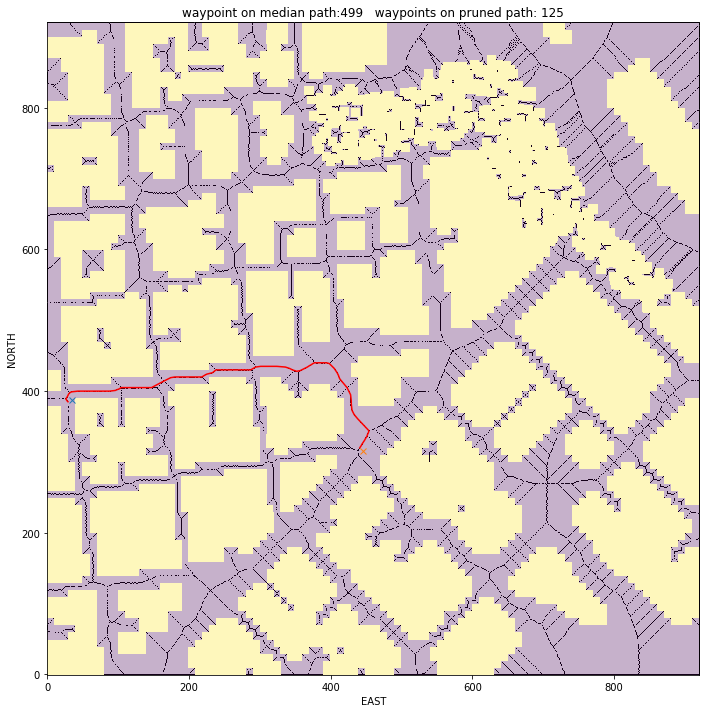

In [23]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.

title = 'waypoint on median path:' + str(len(median_path)) + '   waypoints on pruned path: ' + str(len(pruned_path))

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
plt.title(title)


plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'r')
#plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [10]:
 waypoints = [[p[0] + north_offset, p[1] + east_offset, drone_altitude, 0] for p in pruned_path]
 print(waypoints)   

[[4, -4, 5, 0], [5, -4, 5, 0], [8, -2, 5, 0], [10, -1, 5, 0], [13, 1, 5, 0], [16, 3, 5, 0], [18, 4, 5, 0], [22, 6, 5, 0], [24, 7, 5, 0], [27, 8, 5, 0], [29, 10, 5, 0], [30, 13, 5, 0], [31, 16, 5, 0], [32, 18, 5, 0], [33, 20, 5, 0], [34, 22, 5, 0], [35, 24, 5, 0], [40, 31, 5, 0], [42, 34, 5, 0], [44, 37, 5, 0], [45, 39, 5, 0], [46, 41, 5, 0], [47, 44, 5, 0], [48, 46, 5, 0], [75, 71, 5, 0], [77, 72, 5, 0], [79, 73, 5, 0], [81, 74, 5, 0], [82, 75, 5, 0], [83, 77, 5, 0], [84, 89, 5, 0], [84, 91, 5, 0], [85, 102, 5, 0], [89, 105, 5, 0], [91, 106, 5, 0], [94, 107, 5, 0], [97, 108, 5, 0], [99, 109, 5, 0], [102, 110, 5, 0], [105, 111, 5, 0], [107, 112, 5, 0], [109, 113, 5, 0], [111, 114, 5, 0], [114, 115, 5, 0], [117, 116, 5, 0], [119, 117, 5, 0], [122, 118, 5, 0], [124, 119, 5, 0], [126, 120, 5, 0], [128, 121, 5, 0], [131, 122, 5, 0], [134, 123, 5, 0], [136, 124, 5, 0], [138, 125, 5, 0], [140, 126, 5, 0], [141, 127, 5, 0], [142, 129, 5, 0], [143, 131, 5, 0], [144, 133, 5, 0], [145, 136, 5, 0]